# Projekt na przedmiot podstawy sztucznej inteligencji

## Cel projektu
Celem jest utworzenie modelu sieci konwolucyjnej mogącej klasyfikować gatunek zwierzęcia obecnego na zdjęciu do jednej z następującej klas: <br>
    - kot<br>
    - pies<br>
    - słoń<br>
    - koń<br>
    - lew<br>

Model zostanie wytrenowany z pomocą pakietów scikit-learn oraz tensorflow (keras).

Zbiór danych który został wykorzystany w tym projekcie można znaleźć pod adresem https://www.kaggle.com/datasets/antobenedetti/animals. Zawiera on pięć klas wymienionych powyżej. <br> Etykiety klas i przykładowe elementy znajdują się w katalogu inf. <br> Dane treningowe znajdują się w katalogu train i są podzielone na odrębne katalogi (np zdjęcia psów w katalogu dog). <br> Dane walidacyjne zostały umieszczone w katalogu val.

Zaimportujmy potrzebne biblioteki.

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
from matplotlib import image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle

Zdbiór danych, na którym będzie trenowany model zawiera obrazy w formacie jpg o rozmiarze 512x512 px.
W poniższej komórce ustalamy parametr rozmiaru zdjęć na jakich będzie uczony model. Wszystkie obrazy zostaną przeskalowane do tego rozmiaru. Ten parametr stanowi kompromis pomiędzy dokładnością modelu a zasobami potrzebnymi do jego wyuczenia (im większe zdjęcie tym większa liczba informacji a co za tym idzie większa dokładność klasyfikacji ale również więcej czasu i pamięci jest potrzebne aby wyuczyć taką sieć).

In [2]:
#Constants
image_size = (64, 64)


załadujmy etykiety i spójrzmy na przykładowe elementy:

labels:  [(0, 'dog'), (1, 'elephant'), (2, 'lion'), (3, 'cat'), (4, 'horse')]


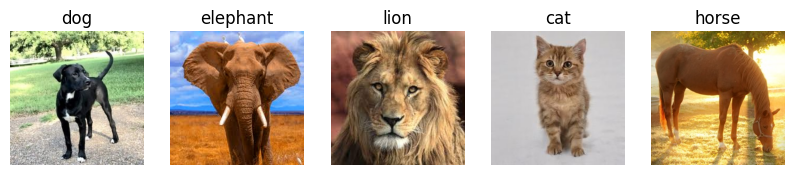

In [5]:
inf_path = os.path.join(os.curdir, 'inf')

class_labels = list(enumerate([ image_name.split('.')[0] for image_name in list(os.walk('inf/'))[0][2]]))
print("labels: ", class_labels)

rows = 1
columns = 5
fig = plt.figure(figsize=(10, 7)) 
for label in class_labels:
    fig.add_subplot(rows, columns, label[0] + 1) 
    img = Image.open(os.path.join(inf_path, label[1] + '.jpg'))
    plt.imshow(img) 
    plt.axis('off') 
    plt.title(label[1]) 

plt.show()


Zdefiniujmy teraz funkcję, za której pomocą załadujemy zbiór danych do pamięci. Jako argumenty należy podać: <br>
-etykiety w formacie takim jak powyżej <br>
-ścieżkę do katalogu, w którym znajdują się dane (również w formacie takim jak powyżej) <br>
Otrzymujemy przetasowane dane z ich etykietami jako X, y.

In [6]:
def loadDataset(labels, path=os.path.join(os.path.curdir, 'train')):
    y = []
    X = []

    for label in labels:
        X_label = []
        new_path = os.path.join(path, label[1])
        for file in list(os.walk(new_path))[0][2]:
            X_label.append(np.array(Image.open(os.path.join(new_path, file)).resize(image_size).convert("RGB")))
            y.append(label[0])

        X += X_label
        print(f"loaded elements from class: {label[1]}.")
    return shuffle(X, y)

Załadujmy zbiór treningowy:

In [8]:
X, y = loadDataset(class_labels, 'train')

loaded elements from class: dog.
loaded elements from class: elephant.
loaded elements from class: lion.
loaded elements from class: cat.
loaded elements from class: horse.


Teraz podzielmy dane i etykiety na zbiór treningowy i testowy. Wykorzystamy w tym celu funkcję train_test_split z modułu sklearn. Rozmiar zbioru testowego stanowi 20% całkowitego rozmiaru zbioru.

In [9]:
X_train, X_test, y_train, y_test = [np.array(data) for data in train_test_split(np.array(X), y, test_size=0.2)]

Ponieważ wykorzystany zbiór danych jest stosunkowo niewielki jak na postawione zadanie, w poniższej komórce definiujemy funkcje, które dodają nam augmentację do naszego zbioru. Dane są generowane poprzez różne transformacje spośród np: obrotów, skalowań, przybliżeń. Parametr augmentation_relative_size określa relatywny rozmiar danych augmentacyjnych, które zostają wygenerowane. Czyli np jeżeli każda klasa zawiera 1000 próbek a parametr jest ustawiony na 0.5 to zostaje wygenerowanych 1000*0.5=500 dodatkowych próbek.

In [10]:


def add_augmentation_for_label(X, augmentation_relative_size = 0.2):
    X_augmented = []
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    it = datagen.flow(X, batch_size=1)
    for i in range(int(len(X) * augmentation_relative_size)):
        X_augmented.append(np.array(next(it)[0], dtype=int))
        
    return X_augmented

def add_augmentation(X: np.array, y: np.array, labels, augmentation_relative_size = 0.2):
    X_augmented = []
    y_augmented = []
    for label in labels:
        X_label = X[np.where(y == label[0])[0]]
        X_augmented_local = add_augmentation_for_label(X_label, augmentation_relative_size)
        y_augmented_local = [label[0]] * len(X_augmented_local)
        X_augmented += X_augmented_local
        y_augmented += y_augmented_local
    return X_augmented, y_augmented

Generujemy zbiory z przekształconymi danymi i dołączamy je do zbioru treningowego. Dane nastepnie jeszcze raz są tasowane. Parametr augmentacji jest równy trzy.

(32337, 32, 32, 3) (97011, 32, 32, 3)


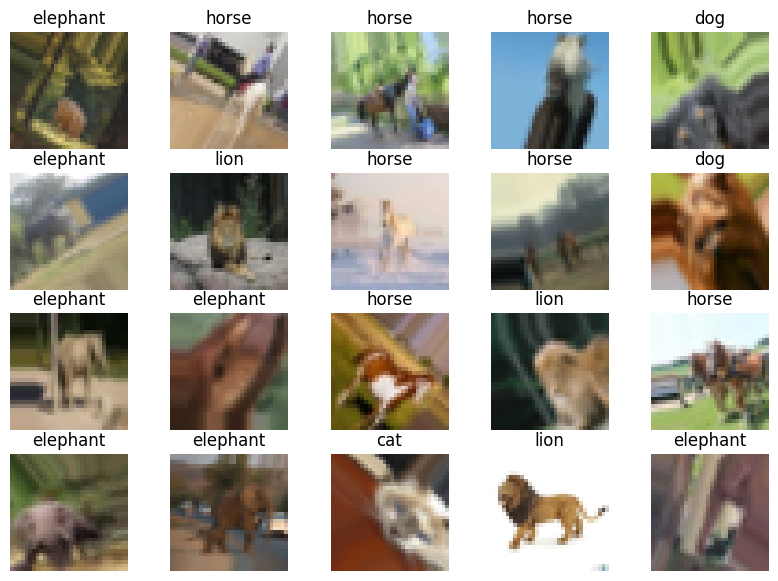

In [12]:


X_augmented, y_augmented = add_augmentation(np.array(X_train), np.array(y_train), class_labels, 3)
print(X_train.shape, np.array(X_augmented).shape)
X_train = np.concatenate((X_train, np.array(X_augmented)), axis=0)
y_train = np.concatenate((y_train, np.array(y_augmented)))
X_train, y_train = shuffle(X_train, y_train)

rows = 4
columns = 5
fig = plt.figure(figsize=(10, 7)) 
for e, (a,b) in enumerate(zip(X_train[3000:3020], y_train[3000:3020])):
    fig.add_subplot(rows, columns, e + 1) 
    plt.imshow(a) 
    plt.axis('off') 
    plt.title(class_labels[b][1])

plt.show()
    

Normalizujemy wartości pikseli tak aby zamiast zakresu {0..255} mieć [0,1]. Zwiększy to stabilność numeryczną obliczeń i poprawi wyniki.

In [13]:

X_train, X_test = X_train / 255.0, X_test / 255.0



In [14]:
print(X_train.shape, y_train.shape)

(129348, 32, 32, 3) (129348,)


Następnie definiujemy model sieci konwolucyjnej. Sieć składa się z 3 bloków konwolucyjnych i 2 warstw fully-connected. Blok składa się z warstwy konwolucyjnej, normalizacyjnej oraz poolingu. Pierwsza warstwa konwolucyjna ma 32 neurony, kolejne dwie mają już 64 w celu lepszej ekstrakcji wysokopoziomowych cech. Do warstw dodałem normalizację w celu uzyskania lepszej dokładności oraz szybszej zbieżności modelu. Funkcją aktywacji jest ELU (exponential linear unit). Funkcja ReLu również sprawiłaby się dobrze, lecz dodanie aktywacji ELU zamiast ReLU dało lepszą stabilność i trochę lepszą dokładność. Prawdopodobnie jest to związane z problemem "martwych neuronów" przy ReLU. Filry konwolucyjne mają rozmiar 3x3. Zastosowanie większych filtrów zwiększało czas obliczeń niekoniecznie polepszając wyniki. W warstwach konwolucyjnych zastosowany jest padding po to, aby nie zmniejszać wymiarów sieci. Pooling to MaxPooling o rozmiarze 2x2 (zmniejsza wymiarowość razy dwa). MaxPooling jest częściej wykorzystywany i osiąga lepsze rezultaty niż averagePooling. Każdy blok zawiera dropout z współczynnikiem 0.25 w celu zmniejszenia overfittingu. Warstwa fully-connected składa się z 128 neuronów, które przyjmują spłaszczony output z ostatniego bloku konwolucyjnego. Następnie następuje normalizacja oraz dropout. Wyniki są przekazywane do ostatniej warstwy składającej się z 5 neuronów z aktywacją softmax.

In [16]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same', input_shape=(image_size +(3, ))))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(5, activation='softmax'))



In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,317 (739.52 KB)

 Trainable params: 188,741 (737.27 KB)

 Non-trainable params: 576 (2.25 KB)

Tworzymy callback, który zapisuje wagi modelu co 5 epok. Dane zapisywane są w plikach danych w wyrażeniu checkpoint_path.

In [18]:
checkpoint_path = './model-{epoch:04d}.ckpt.keras'
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

import math
n_batches = len(X_train) / batch_size
n_batches = math.ceil(n_batches)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_freq=5*n_batches)

Kompilujemy model. Jako optymizator stosujemy adam a funkcja straty to entropia krzyżowa. Nastepnie model jest trenowany.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_test, y_test),
                    callbacks=[cp_callback])

2024-06-06 14:49:21.882384: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1589428224 exceeds 10% of free system memory.


Epoch 1/20


/home/adam/Documents/studia/psi/animals/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4043/4043 ━━━━━━━━━━━━━━━━━━━━ 126s 30ms/step - accuracy: 0.4485 - loss: 1.3787 - val_accuracy: 0.7781 - val_loss: 0.6159
Epoch 2/20
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 126s 31ms/step - accuracy: 0.6540 - loss: 0.8870 - val_accuracy: 0.6846 - val_loss: 0.8434
Epoch 3/20
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 110s 27ms/step - accuracy: 0.7118 - loss: 0.7515 - val_accuracy: 0.8260 - val_loss: 0.4574
Epoch 4/20
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 125s 31ms/step - accuracy: 0.7411 - loss: 0.6842 - val_accuracy: 0.8597 - val_loss: 0.3761
Epoch 5/20
4041/4043 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7588 - loss: 0.6359
Epoch 5: saving model to ./model-0005.ckpt.keras
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 102s 25ms/step - accuracy: 0.7588 - loss: 0.6359 - val_accuracy: 0.7573 - val_loss: 0.6429
Epoch 6/20
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 88s 22ms/step - accuracy: 0.7593 - loss: 0.6330 - val_accuracy: 0.8482 - val_loss: 0.4067
Epoch 7/20
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 95s 23ms/step - accuracy: 0.7763 - loss: 0.59

Wyświetlamy statystyki dokładności modelu:

85/85 - 0s - 6ms/step - accuracy: 0.8935 - loss: 0.2715
0.8935064673423767


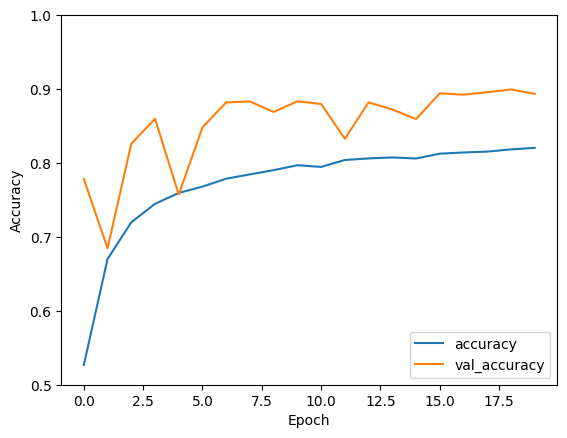

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)

Udało nam się osiągnąć niemal 90% dokładności.

Confusion matrix:

In [23]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
confusion_matrix(y_test, y_pred)

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[530,   2,   5,   3,   4],
       [  0, 438,  34,   4,  83],
       [  6,  36, 418,   1,  36],
       [  8,   0,   4, 549,   3],
       [  8,  27,  22,   1, 473]])

Z confusion matrix można wysnuć, że np słoń jest podobny do lwa. Może tak być ponieważ np szerokie uszy słonia mogą przypominać grzywę lwa. Również widać, że słoń jest często mylony z koniem.

Zapisujemy model:

In [24]:

model.save('./model.ckpt.keras')

Początkowo sieć składała się z warstwy konwolucyjnej o rozmiarze 32 neuronów z filtrem 3x3, maxpoolingiem 2x2, kolejnym jądrem tym razem składającym się z 64 neuronów 3x3, kolejnym poolingiem oraz jądrem z 64 neuronów 3x3 (można sądzić, że rozpoznawanie zwierząt jest zadaniem,  które zawiera dużo skomplikowanych cech średnio i wysoko poziomowych z porównaniem mniejszej ilości cech niskopoziomowych. Stąd zwiększenie liczby neuronów w kolejnych warstwach). Sieć jest podłączona do warstw fully connected z 32 i 5 neuronami wyjściowymi z aktywacją softmax. Taka sieć bez augmentacji osiąga ok 80% dokładności na zbiorze walidacyjnym.


In [41]:
image_size = (32, 32)
num_of_epochs = 20
augmentation_rate = 0

X, y = loadDataset(class_labels, 'train')
X_train, X_test, y_train, y_test = [np.array(data) for data in train_test_split(np.array(X), y, test_size=0.2)]


loaded elements from class: dog.
loaded elements from class: elephant.
loaded elements from class: lion.
loaded elements from class: cat.
loaded elements from class: horse.


In [43]:

modelv1 = models.Sequential()

modelv1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size +(3, ))))
modelv1.add(layers.MaxPooling2D((2, 2)))
modelv1.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelv1.add(layers.MaxPooling2D((2, 2)))
modelv1.add(layers.Conv2D(64, (3, 3), activation='relu'))


modelv1.add(layers.Flatten())
modelv1.add(layers.Dense(64, activation='relu'))
modelv1.add(layers.Dense(5, activation='softmax'))

modelv1.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,245 (477.52 KB)

 Trainable params: 122,245 (477.52 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
modelv1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = modelv1.fit(X_train, y_train, epochs=num_of_epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/20


/home/adam/Documents/studia/psi/animals/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.3662 - loss: 3.7200 - val_accuracy: 0.6115 - val_loss: 0.9704
Epoch 2/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6419 - loss: 0.9177 - val_accuracy: 0.6846 - val_loss: 0.7990
Epoch 3/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7200 - loss: 0.7136 - val_accuracy: 0.7217 - val_loss: 0.7239
Epoch 4/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.7469 - loss: 0.6511 - val_accuracy: 0.7199 - val_loss: 0.7153
Epoch 5/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7675 - loss: 0.5924 - val_accuracy: 0.7380 - val_loss: 0.6767
Epoch 6/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7953 - loss: 0.5139 - val_accuracy: 0.7633 - val_loss: 0.6349
Epoch 7/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8115 - loss: 0.4748 - val_accuracy: 0.7785 - val_loss: 0.5807
Epoch 8/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8391 - loss: 0.4216 - val_accuracy: 

85/85 - 0s - 4ms/step - accuracy: 0.7826 - loss: 0.8667
0.7825602889060974


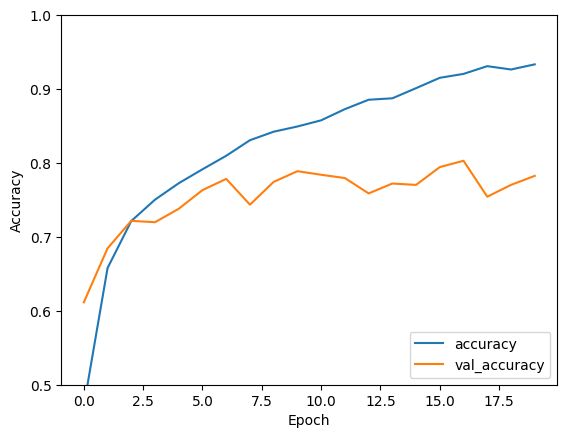

In [45]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelv1.evaluate(X_test,  y_test, verbose=2)



historyW = [history, {"image_size" : image_size, "epochs" : num_of_epochs, "augmentation_rate": augmentation_rate}]
pickle.dump(historyW, open("./history/histv1.pkl", "wb"))
model.save('./modelv1.ckpt.keras')

print(test_acc)


Niestety, na takiej sieci zachodzi mocny overfitting. Dlatego do każdego bloku konwolucyjnego dodałem dropout o wartości 0.25 oraz wprowadziłem dane augmentacyjne z współczynnikiem 1. Dane zostały tym razem znormalizowane. Taka sieć osiąga już 85% dokładności.


In [46]:
image_size = (32, 32)
num_of_epochs = 20
augmentation_rate = 1

X, y = loadDataset(class_labels, 'train')
X_train, X_test, y_train, y_test = [np.array(data) for data in train_test_split(np.array(X), y, test_size=0.2)]

X_augmented, y_augmented = add_augmentation(np.array(X_train), np.array(y_train), class_labels, augmentation_rate)
X_train = np.concatenate((X_train, np.array(X_augmented)), axis=0)
y_train = np.concatenate((y_train, np.array(y_augmented)))
X_train, y_train = shuffle(X_train, y_train)

X_train, X_test = X_train / 255.0, X_test / 255.0

loaded elements from class: dog.
loaded elements from class: elephant.
loaded elements from class: lion.
loaded elements from class: cat.
loaded elements from class: horse.


In [48]:
modelv2 = models.Sequential()

modelv2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size +(3, ))))
modelv2.add(layers.MaxPooling2D((2, 2)))
modelv2.add(layers.Dropout(0.25))

modelv2.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelv2.add(layers.MaxPooling2D((2, 2)))
modelv2.add(layers.Dropout(0.25))

modelv2.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelv2.add(layers.Dropout(0.25))


modelv2.add(layers.Flatten())
modelv2.add(layers.Dense(64, activation='relu'))
modelv2.add(layers.Dropout(0.25))
modelv2.add(layers.Dense(5, activation='softmax'))

modelv2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,245 (477.52 KB)

 Trainable params: 122,245 (477.52 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
modelv2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = modelv2.fit(X_train, y_train, epochs=num_of_epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/20


2024-06-06 13:14:14.112193: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264904704 exceeds 10% of free system memory.


674/674 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.3254 - loss: 1.4974 - val_accuracy: 0.6479 - val_loss: 0.9257
Epoch 2/20
674/674 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5623 - loss: 1.0869 - val_accuracy: 0.7306 - val_loss: 0.6827
Epoch 3/20
674/674 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6437 - loss: 0.9254 - val_accuracy: 0.7662 - val_loss: 0.6075
Epoch 4/20
674/674 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6764 - loss: 0.8287 - val_accuracy: 0.8041 - val_loss: 0.5127
Epoch 5/20
674/674 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6877 - loss: 0.7961 - val_accuracy: 0.7959 - val_loss: 0.5595
Epoch 6/20
674/674 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7108 - loss: 0.7548 - val_accuracy: 0.8122 - val_loss: 0.4760
Epoch 7/20
674/674 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7264 - loss: 0.7130 - val_accuracy: 0.8163 - val_loss: 0.4665
Epoch 8/20
674/674 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7339 - loss: 0.6823 - val_accuracy: 0.82

85/85 - 0s - 3ms/step - accuracy: 0.8545 - loss: 0.3728
0.8545454740524292


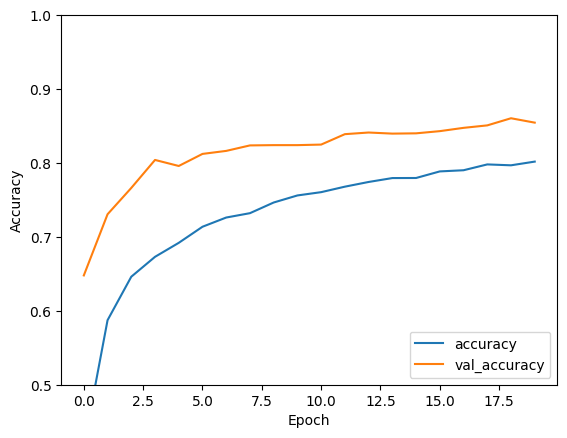

In [50]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelv2.evaluate(X_test,  y_test, verbose=2)



historyW = [history, {"image_size" : image_size, "epochs" : num_of_epochs, "augmentation_rate": augmentation_rate}]
pickle.dump(historyW, open("./history/histv2.pkl", "wb"))
model.save('./modelv2.ckpt.keras')

print(test_acc)


Kolejne zwiększanie współczynnika augmentacji zmniejszało overfitting i zwiększało dokładność aż do 85% przy współczynniku 4. 

In [62]:
image_size = (32, 32)
num_of_epochs = 20
augmentation_rate = 3

X, y = loadDataset(class_labels, 'train')
X_train, X_test, y_train, y_test = [np.array(data) for data in train_test_split(np.array(X), y, test_size=0.2)]

X_augmented, y_augmented = add_augmentation(np.array(X_train), np.array(y_train), class_labels, augmentation_rate)
X_train = np.concatenate((X_train, np.array(X_augmented)), axis=0)
y_train = np.concatenate((y_train, np.array(y_augmented)))
X_train, y_train = shuffle(X_train, y_train)

X_train, X_test = X_train / 255.0, X_test / 255.0

loaded elements from class: dog.
loaded elements from class: elephant.
loaded elements from class: lion.
loaded elements from class: cat.
loaded elements from class: horse.


In [54]:
#taki sam jak v2
modelv3 = models.Sequential()

modelv3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size +(3, ))))
modelv3.add(layers.MaxPooling2D((2, 2)))
modelv3.add(layers.Dropout(0.25))

modelv3.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelv3.add(layers.MaxPooling2D((2, 2)))
modelv3.add(layers.Dropout(0.25))

modelv3.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelv3.add(layers.Dropout(0.25))


modelv3.add(layers.Flatten())
modelv3.add(layers.Dense(64, activation='relu'))
modelv3.add(layers.Dropout(0.25))
modelv3.add(layers.Dense(5, activation='softmax'))


/home/adam/Documents/studia/psi/animals/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
modelv3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = modelv3.fit(X_train, y_train, epochs=num_of_epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/20


/home/adam/Documents/studia/psi/animals/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1348/1348 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.3721 - loss: 1.4375 - val_accuracy: 0.7280 - val_loss: 0.7359
Epoch 2/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5943 - loss: 1.0249 - val_accuracy: 0.7662 - val_loss: 0.5963
Epoch 3/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.6524 - loss: 0.8971 - val_accuracy: 0.7833 - val_loss: 0.5689
Epoch 4/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.6875 - loss: 0.8119 - val_accuracy: 0.7855 - val_loss: 0.5379
Epoch 5/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.7023 - loss: 0.7671 - val_accuracy: 0.7989 - val_loss: 0.5183
Epoch 6/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.7159 - loss: 0.7371 - val_accuracy: 0.7967 - val_loss: 0.5067
Epoch 7/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7295 - loss: 0.7036 - val_accuracy: 0.8193 - val_loss: 0.4797
Epoch 8/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7401 - loss: 0.68

85/85 - 0s - 4ms/step - accuracy: 0.8523 - loss: 0.3716


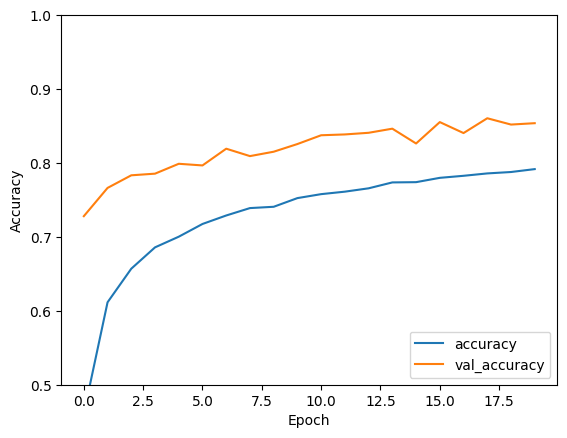

In [57]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelv3.evaluate(X_test,  y_test, verbose=2)



historyW = [history, {"image_size" : image_size, "epochs" : num_of_epochs, "augmentation_rate": augmentation_rate}]
pickle.dump(historyW, open("./history/histv3.pkl", "wb"))
model.save('./modelv3.ckpt.keras')


Następnie do modelu dodałem warstwę normalizacyjną po każdej konwolucji w celu przyspieszenia trenowania oraz osiągnięcia większej stabilności. Zmieniłem również funkcję aktywacji w sieci konwolucyjnej z relu na elu w celu szybszej zbieżności i rozwiązania problemu umierających neuronów.

In [63]:
modelv4 = models.Sequential()

modelv4.add(layers.Conv2D(32, (3, 3), activation='elu', input_shape=(image_size +(3, ))))
modelv4.add(layers.BatchNormalization())
modelv4.add(layers.MaxPooling2D((2, 2)))
modelv4.add(layers.Dropout(0.25))

modelv4.add(layers.Conv2D(64, (3, 3), activation='elu'))
modelv4.add(layers.BatchNormalization())
modelv4.add(layers.MaxPooling2D((2, 2)))
modelv4.add(layers.Dropout(0.25))

modelv4.add(layers.Conv2D(64, (3, 3), activation='elu'))
modelv4.add(layers.BatchNormalization())
modelv4.add(layers.Dropout(0.25))


modelv4.add(layers.Flatten())
modelv4.add(layers.Dense(64, activation='relu'))
modelv4.add(layers.BatchNormalization())
modelv4.add(layers.Dropout(0.25))
modelv4.add(layers.Dense(5, activation='softmax'))

/home/adam/Documents/studia/psi/animals/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
modelv4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = modelv4.fit(X_train, y_train, epochs=num_of_epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/20


/home/adam/Documents/studia/psi/animals/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1348/1348 ━━━━━━━━━━━━━━━━━━━━ 38s 26ms/step - accuracy: 0.4251 - loss: 1.4917 - val_accuracy: 0.7095 - val_loss: 0.7566
Epoch 2/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.6049 - loss: 1.0008 - val_accuracy: 0.5614 - val_loss: 1.1176
Epoch 3/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.6639 - loss: 0.8576 - val_accuracy: 0.6538 - val_loss: 0.8486
Epoch 4/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.6965 - loss: 0.7766 - val_accuracy: 0.7788 - val_loss: 0.5709
Epoch 5/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.7265 - loss: 0.7105 - val_accuracy: 0.8223 - val_loss: 0.4482
Epoch 6/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.7449 - loss: 0.6706 - val_accuracy: 0.7210 - val_loss: 0.6807
Epoch 7/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.7534 - loss: 0.6403 - val_accuracy: 0.8445 - val_loss: 0.4072
Epoch 8/20
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.7628 - loss: 0.61

85/85 - 0s - 3ms/step - accuracy: 0.8709 - loss: 0.3363


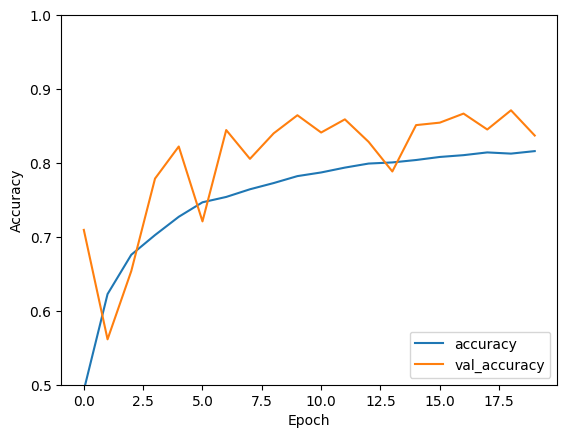

In [66]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelv4.evaluate(X_test,  y_test, verbose=2)


historyW = [history, {"image_size" : image_size, "epochs" : num_of_epochs, "augmentation_rate": augmentation_rate}]
pickle.dump(historyW, open("./history/histv4.pkl", "wb"))
model.save('./modelv4.ckpt.keras')

Dokładność modelu po 20 epokach jest podobna. Chociaż proces uczenia jest mniej stabilny to udało się zdobyć 86% dokładności na zbiorze testowym.

Elementami, które można jeszcze poprawić jest rozmiar obrazka. Można go zwiększyć z 32x32 do np 64x64 (albo nawet więcej. Możliwe rozmiary: 128x128, 256x256, 512x512), lecz wymaga to dużej mocy obliczeniowej, która niestety nie dysponuję. Zwiększenie rozmiaru pociąga za sobą również rozbudowanie rozmiaru sieci konwolucyjnej. Można np. dodać 4 blok konwolucyjny. Można również jeszcze zwiększyć współczynnik augmentacji. Ilość elementów w klasie jest bardzo podobna ale nie równa. Jeszcze jedną opcją jest dokładne wyrównanie elementów w każdej klasie tak aby model był idealnie zbalansowany.

## Podsumowanie prób

{'image_size': (32, 32), 'epochs': 20, 'augmentation_rate': 3}
{'image_size': (32, 32), 'epochs': 20, 'augmentation_rate': 1}
{'image_size': (32, 32), 'epochs': 20, 'augmentation_rate': 3}
{'image_size': (32, 32), 'epochs': 20, 'augmentation_rate': 0}


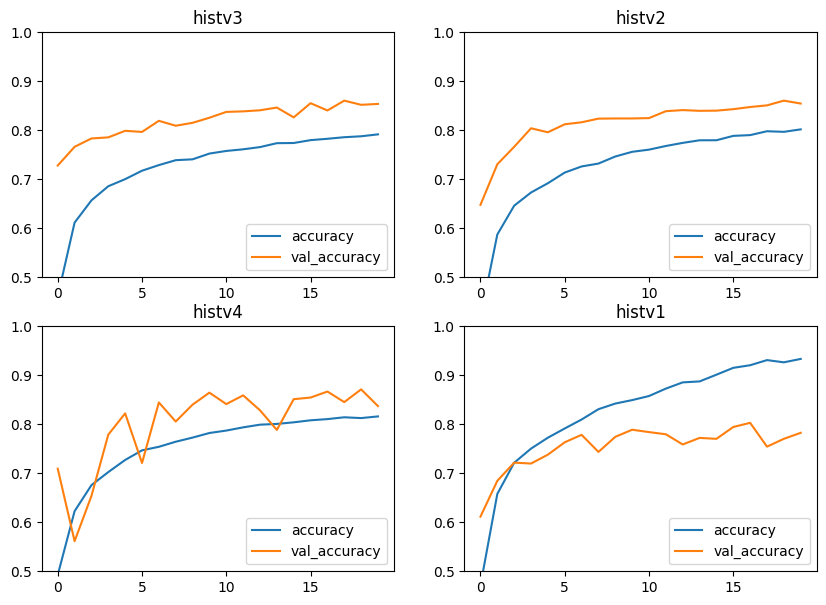

In [27]:
rows = 2
columns = 2
fig = plt.figure(figsize=(10, 7)) 
for e, f in enumerate(list(os.walk('history/'))[0][2]):
    fig.add_subplot(rows, columns, e + 1) 
    his = pickle.load(open('history/' + f, 'rb'))
    print(his[1])
    plt.plot(his[0].history['accuracy'], label='accuracy')
    plt.plot(his[0].history['val_accuracy'], label = 'val_accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title(f.split('.')[0]) 

plt.show()